In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as scp

from fake_spectra.plot_spectra import PlottingSpectra
from fake_spectra.spectra import Spectra

import sys
sys.path.append('../../py/')

from cosmoSim import cosmoSim

In [2]:
tcDM_RUNS1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(9)] + ['run_2cDM_L3N256_HY_power00_sigma1']
tcDM_RUNS2 = [ f'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_{i}' for i in range(9)] + ['run_2cDM_L3N256_HY_powerm2m2_sigma1']
CDM_RUNS = [ f'run_CDM_L3N256_HY_dir_{i}' for i in range(9)] + ['run_CDM_L3N256_HY']
runs = tcDM_RUNS1 + tcDM_RUNS2 + CDM_RUNS
runs

['run_2cDM_L3N256_HY_power00_sigma1_dir_0',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_1',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_2',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_3',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_4',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_5',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_6',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_7',
 'run_2cDM_L3N256_HY_power00_sigma1_dir_8',
 'run_2cDM_L3N256_HY_power00_sigma1',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_0',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_1',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_2',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_3',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_4',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_5',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_6',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_7',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_8',
 'run_2cDM_L3N256_HY_powerm2m2_sigma1',
 'run_CDM_L3N256_HY_dir_0',
 'run_CDM_L3N256_HY_dir_1',
 'run_CDM_L3N256_HY_dir_2',
 'run_CDM_L3N256_HY_dir_3',


In [3]:
elem = 'H'
ion = 1
line = 1215

offset = 0

In [5]:
def get_avg_func(run_list):
    interps = []
    sp = Spectra(num=4,base=f"../../data_prods/{run_list[0]}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    kv, Pk = sp.get_flux_power_1D(elem, ion, line)
    inf = np.amin(kv)
    sup = np.amax(kv)
    for run in run_list:
        sp = Spectra(num=4,base=f"../../data_prods/{run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
        kv, Pk = sp.get_flux_power_1D(elem, ion, line)
        lims = [np.amin(kv), np.amax(kv)]
        
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]
        
        interps.append(scp.interpolate.interp1d(kv, Pk))
    return (inf, sup), interps

def get_samples(domain, interpf_list):
    return [ interpf(domain) for interpf in interpf_list ]

def calculate_averages(domain, interps):
    samps = get_samples(domain, interps)
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def calculate_ratios(domain, interps_numerator, interps_denominator):
    samps_numerator = get_samples(domain, interps_numerator)
    samps_denominator = get_samples(domain, interps_denominator)

    samps = [ num / den for num, den in zip(samps_numerator, samps_denominator) ]
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def get_averages(CDM_runs, tcDM_runs, ratios=False):

    clims, CDM_interps = get_avg_func(CDM_runs)
    tlims, tcDM_interps = get_avg_func(tcDM_runs)

    inf = clims[0] if clims[0] > tlims[0] else tlims[0]
    sup = clims[1] if clims[1] < tlims[1] else tlims[1]

    domain = np.geomspace(inf, sup, num=1000)

    if ratios:
        ratio_samps, ratios_ten, ratios_ninety = calculate_ratios(domain, tcDM_interps, CDM_interps)
        return domain, (ratio_samps, ratios_ten, ratios_ninety)
    else:
        CDM_avg, CDM_ten, CDM_ninety = calculate_averages(domain, CDM_interps)
        tcDM_avg, tcDM_ten, tcDM_ninety = calculate_averages(domain, tcDM_interps)

        return domain, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety)

In [6]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams['font.size']=10

# matplotlib.rcParams['font.family'] = 'serif'
# matplotlib.rc('text', usetex=True)

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'
sidm_color = 'm'

ALPHA=0.6

FIG_HEIGHT = 8.5
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )


5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_4/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184

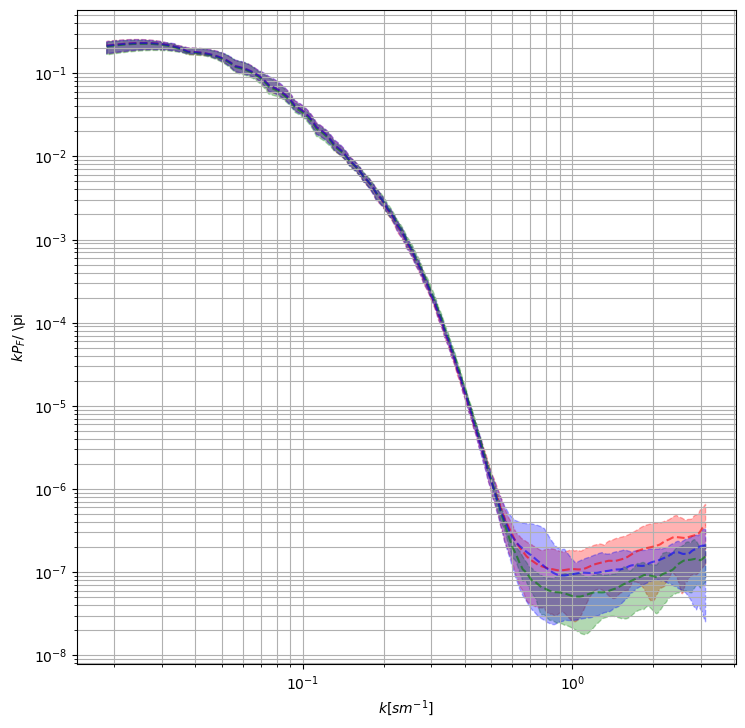

In [22]:
fig, ax = plt.subplots(1,1, figsize=FIGSIZE)

tcDM_runs = tcDM_RUNS2

bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_RUNS, tcDM_runs)

ax.plot(bins, bins * CDM_avg / np.pi, alpha=ALPHA, color=cdm_color, linestyle='dashed')
ax.fill_between(bins, bins * CDM_ten / np.pi, bins * CDM_ninety / np.pi, alpha=0.5*ALPHA, color=cdm_color, linestyle='dashed')

ax.plot(bins, bins * tcDM_avg / np.pi, alpha=ALPHA, color=m2m2_color, linestyle='dashed')
ax.fill_between(bins, bins * tcDM_ten / np.pi, bins * tcDM_ninety / np.pi, alpha=0.5*ALPHA, color=m2m2_color, linestyle='dashed')

tcDM_runs = tcDM_RUNS1
bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_RUNS, tcDM_runs)
ax.plot(bins, bins * tcDM_avg / np.pi, alpha=ALPHA, color=zz_color, linestyle='dashed')
ax.fill_between(bins, bins * tcDM_ten / np.pi, bins * tcDM_ninety / np.pi, alpha=0.5*ALPHA, color=zz_color, linestyle='dashed')

ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True, which="both", ls="-")

ax.set_xlabel('$k [s m^{-1}]$')
ax.set_ylabel('$k P_{F}$/ \\pi')

plt.savefig('tmp_pk1D.png', dpi=DPI)
plt.show()

Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_3/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../

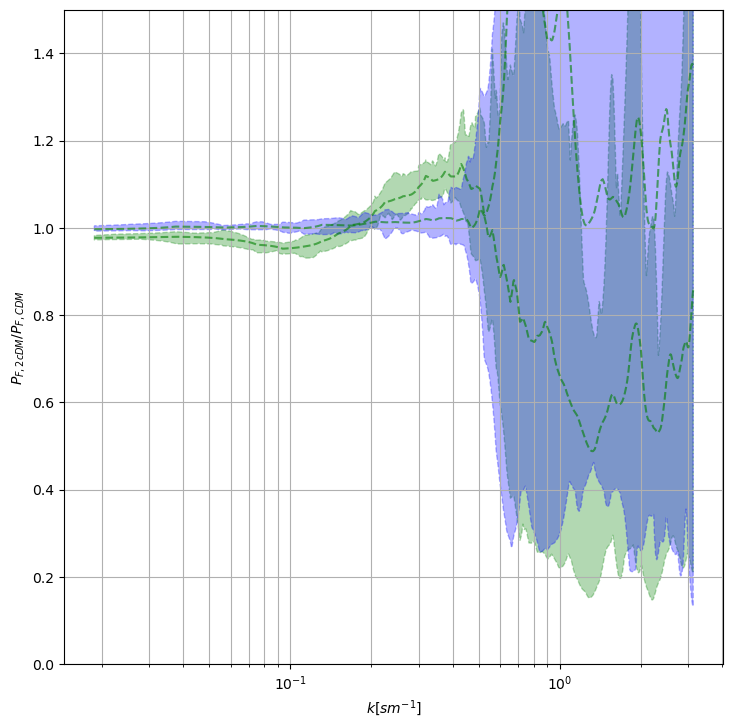

In [21]:
fig, ax = plt.subplots(1,1, figsize=FIGSIZE)

tcDM_runs = tcDM_RUNS2

bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_RUNS, tcDM_runs)

bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_RUNS, tcDM_runs, ratios=True)

ax.plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color, linestyle='dashed')
ax.fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=m2m2_color, linestyle='dashed')

tcDM_runs = tcDM_RUNS1

bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_RUNS, tcDM_runs, ratios=True)

ax.plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color, linestyle='dashed')
ax.fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=zz_color, linestyle='dashed')

ax.set_ylim(0, 1.5)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True, which="both", ls="-")
ax.set_xlabel('$k [s m^{-1}]$')
ax.set_ylabel('$P_{F, 2cDM}/P_{F, CDM}$')

plt.savefig('tmp_pk1D_ratio.png', dpi=DPI)

plt.show()

In [5]:
run = cosmoSim(runs[0])
num, base = run.get_fake_spectra_savefile_path(4)

sp = Spectra(num=num, base=base, cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")

Reading pre-computed spectra (from file /mnt/c/projects/dm_sims/data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_0/SPECTRA_003/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.001540269290691  z= 3.9916277163626868


/mnt/c/projects/dm_sims/jupyter/global/../../py/cosmoSim.py:57: UserWarning: Vkick not explicitly set in run run_2cDM_L3N256_HY_power00_sigma1_dir_0! Assuming 100 km/s...
  warnings.warn(f'Vkick not explicitly set in run {self.run_name}! Assuming 100 km/s...')


In [6]:
sp = Spectra(num=4,base="../../data_prods/run_2cDM_L3N256_HY_power00_sigma1/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")

kv, Pk = sp.get_flux_power_3D(elem=elem, ion=ion, line=line)

# just use what's given lol

Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_004/rand_spectra_DLA.hdf5  )


5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807


NameError: name 'CurrentMPIComm' is not defined

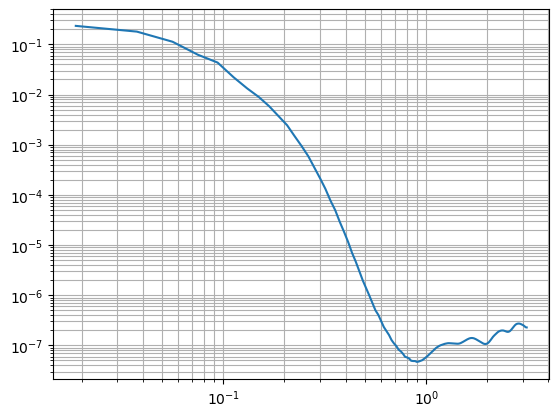

In [10]:
fig, a = plt.subplots(1, 1)
a.plot(kv, kv * 1 / np.pi * Pk )

a.set_yscale("log")
a.set_xscale("log")
a.grid(True, which="both", ls="-")
#a.set_xlim(10**-3, 10**-1)
plt.show()


Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )


5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightline

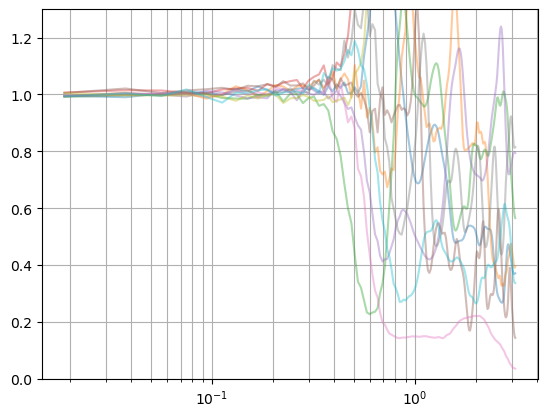

In [8]:
fig, a = plt.subplots(1, 1)


for tcdm_run, cdm_run in zip(tcDM_RUNS1, CDM_RUNS):
    sp = Spectra(num=4,base=f"../../data_prods/{tcdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    spc = Spectra(num=4,base=f"../../data_prods/{cdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    kv, Pk = sp.get_flux_power_1D(elem, ion, line)
    _, Pkc = spc.get_flux_power_1D(elem, ion, line)
    a.plot(kv, Pk/Pkc, alpha=0.4 )
    
    
#a.set_yscale("log")
a.set_ylim(0, 1.3)
a.set_xscale("log")
a.grid(True, which="both", ls="-")
plt.show()

Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729

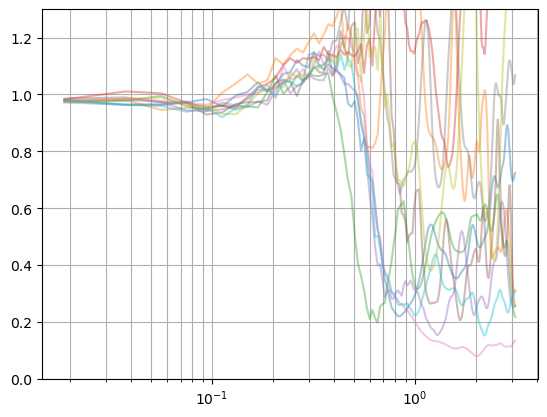

In [9]:
fig, a = plt.subplots(1, 1)


for tcdm_run, cdm_run in zip(tcDM_RUNS2, CDM_RUNS):
    sp = Spectra(num=4,base=f"../../data_prods/{tcdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    spc = Spectra(num=4,base=f"../../data_prods/{cdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    kv, Pk = sp.get_flux_power_1D(elem, ion, line)
    _, Pkc = spc.get_flux_power_1D(elem, ion, line)
    a.plot(kv, Pk/Pkc, alpha=0.4 )
    
    
#a.set_yscale("log")
a.set_ylim(0, 1.3)
a.set_xscale("log")
a.grid(True, which="both", ls="-")
plt.show()

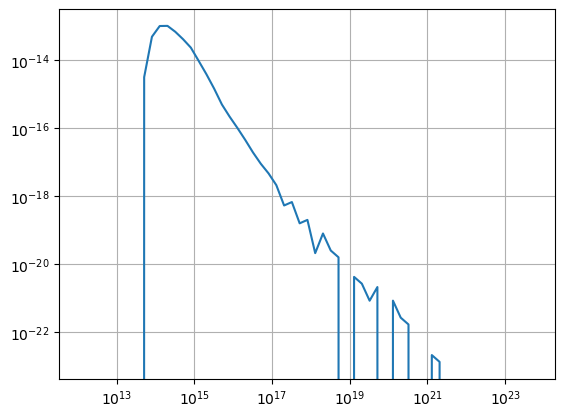

In [10]:
dlogN=0.2
minN=13
maxN=23.
color="blue"
moment=False
dX=True
line=True

(NHI,f_N)=sp.column_density_function(elem, ion, dlogN,minN-1,maxN+1,dX=dX, line=line)

fig, a = plt.subplots(1, 1)
a.plot(NHI, f_N, alpha=1 )

a.set_yscale("log")
a.set_xscale("log")
a.grid(True, which="both", ls="-")

plt.show()

Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )


5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_0/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_1/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0009078021796154  z= 2.995420558949888
Reading pre-computed spectra (from file ../../data_prods/run_2cDM_L3N256_HY_power00_sigma1_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightlines. resolution:  1.0014115820184988  z= 2.9999151729465807
Reading pre-computed spectra (from file ../../data_prods/run_CDM_L3N256_HY_dir_2/SPECTRA_004/rand_spectra_DLA.hdf5  )
5000  sightline

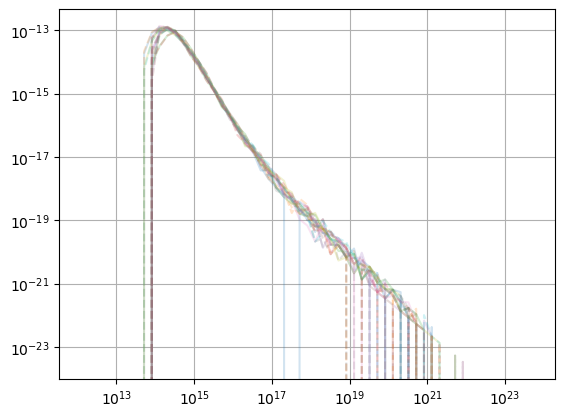

In [13]:
fig, a = plt.subplots(1, 1)

for tcdm_run, cdm_run in zip(tcDM_RUNS1, CDM_RUNS):
    sp = Spectra(num=4,base=f"../../data_prods/{tcdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    spc = Spectra(num=4,base=f"../../data_prods/{cdm_run}/", cofm=None, axis=None, savefile="rand_spectra_DLA.hdf5")
    NHI, f_N = sp.column_density_function(elem, ion, dlogN,minN-1,maxN+1,dX=dX, line=line)
    NHIc, f_Nc = spc.column_density_function(elem, ion, dlogN,minN-1,maxN+1,dX=dX, line=line)
    a.plot(NHI, f_N, alpha=0.2 )
    a.plot(NHIc, f_Nc, '--', alpha=0.2)
    
    
a.set_yscale("log")
#a.set_ylim(0, 1.3)
a.set_xscale("log")
a.grid(True, which="both", ls="-")
plt.show()

In [12]:


ps = PlottingSpectra(num=4,base="/media/usb/run_2cDM_L3N256_HY_power00_sigma1/", label="thisisatest",savefile="/media/usb/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_004/rand_spectra_DLA.hdf5")
ps.plot_cddf("H",1)

Reading pre-computed spectra (from file /media/usb/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_004/rand_spectra_DLA.hdf5  )


OSError: Could not read saved data from: /media/usb/run_2cDM_L3N256_HY_power00_sigma1/SPECTRA_004/rand_spectra_DLA.hdf5. If the file does not exist, try using reload_file=True

137

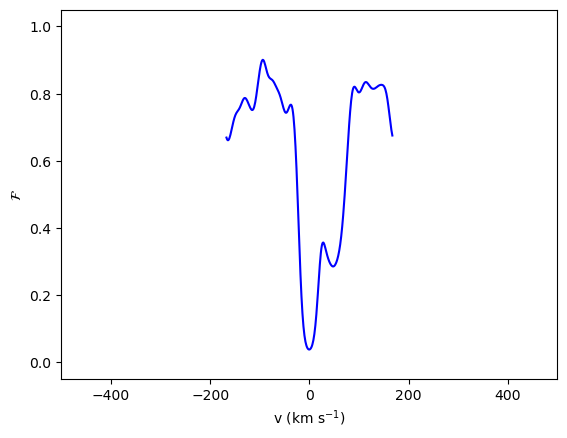

In [ ]:
ps.plot_spectrum("H", 1, 1215, 0)